# <u>Trading System Development - Part 02</u>

### Strategy Rules
1. 1Hr Timeframe
2. 200 SMA
3. 10,3 Super Trend
4. Stop-Reverse Strategy
5. NIFTY index

#### LONG Entry Rules
1. 1Hr. Close > 200 SMA
2. Long signal on SuperTrend
3. (No ST long signals will be considered if close is below 200 SMA)

#### SHORT Entry Rules
1. 1Hr. Close < 200 SMA
2. Short signal on SuperTrend
3. (No ST short signals will be considered if close is above 200 SMA)



In [113]:
#importing Libraries

import pandas as pd
import numpy as np
import datetime
import pandas_ta as ta

# <u>1. Data Cleaning</u>

In [7]:
#Add FilePath
raw_data = pd.read_csv('/Users/sunnykalyani/Downloads/nifty50.csv')

In [8]:
raw_data['date'] = raw_data['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
raw_data['time'] = raw_data['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time())
raw_data['datetime'] = raw_data['datetime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [154]:
nifty_data = raw_data[['datetime','date','time','open','high','low','close']]

In [155]:
nifty_data.set_index('datetime',inplace=True, drop=True)

# <u>2. Data Resampling (1 Hr)</u>

In [157]:
def subDatetime(x):
    #Diwali Muraat Trading Hours(2015-11-11, 2016-10-30, 2017-10-9, 2018-11-7)(-30mins)
    if (x.date() == datetime.date(2015,11,11)) or (x.date() == datetime.date(2016,10,30)) or (x.date() == datetime.date(2017,10,19)) or (x.date() == datetime.date(2018,11,7)):
        return x - datetime.timedelta(minutes=30)

    #2021 Feb NSE Down (Stopped at 10:09 started back at 15:45)(-45mins)
    elif (x.date() == datetime.date(2021,2,24)) and (x.time() > datetime.time(15,30)):
        return x - datetime.timedelta(minutes=45)

    #All other times(-15mins)
    else:
        return x - datetime.timedelta(minutes=15)

def addDatetime(x):
    if (x.date() == datetime.date(2015,11,11)) or (x.date() == datetime.date(2016,10,30)) or (x.date() == datetime.date(2017,10,19))or(x.date() == datetime.date(2018,11,7)):
        return x + datetime.timedelta(minutes=30)
    elif (x.date() == datetime.date(2021,2,24)) and (x.time() > datetime.time(15,30)):
        return x + datetime.timedelta(minutes=45)
    else:
        return x + datetime.timedelta(minutes=15)

In [159]:
nifty_data.reset_index(inplace=True)
nifty_data['datetime'] = nifty_data['datetime'].apply(subDatetime)
nifty_data.set_index('datetime',drop=True,inplace=True)

/var/folders/bk/x797cmpn36q8wvkjr3rfw85w0000gn/T/ipykernel_73632/1021208801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nifty_data['datetime'] = nifty_data['datetime'].apply(subDatetime)


In [160]:
nifty_data = nifty_data.resample('1H', offset=).agg({
    'date':'first',
    'time':'first',
    'open':'first',
    'high':'max',
    'low':'min',
    'close':'last'
})

In [161]:
nifty_data.reset_index(inplace=True)
nifty_data['datetime'] = nifty_data['datetime'].apply(addDatetime)

In [162]:
nifty_data.dropna(inplace=True)
nifty_data.reset_index(inplace=True, drop=True)

# <u>3. Computing Indicators (200SMA & SuperTrend)</u>

#### 1. <u>Calculate Average True Range (ATR)</u>

        The Average True Range (ATR) is a measure of market volatility. 
        
        The true range for each period is the greatest of the following:
        1. The difference between the current high and the current low.
        2. The difference between the current high and the previous close.
        3. The difference between the current low and the previous close.



#### 2. <u>Calculate Basic Upper and Lower Bands</u>

        The basic upper and lower bands are calculated using the ATR and a multiplier (commonly set to 3).

        Basic Upper Band = ( (High + Low) / 2 ) + (Multiplier * ATR)
        Basic Lower Band = ( (High + Low) / 2 ) - (Multiplier * ATR)



#### 3. <u>Define Final Upper and Lower Bands</u>

        The final upper and lower bands are determined based on the previous period's bands and the Previous close.

        If the previous close is greater than the previous final upper band, then the current final upper band is the current basic upper band. 
        ELSE min(CurrentBasicUpperBand, PrevFinalUpperBand)
        
        
        If the previous close is less than the previous final lower band, then the current final lower band is the current basic lower band.
        ELSE max(CurrentBasicLowerBand, PrevFinalLowerBand)
        



#### 4. <u>Calculate SuperTrend</u>

####    (A) Check for First SuperTrend Value, based on first Crossover
        -If Previous close is less than previous final upper band, and current close is greater than current final upper band, So, current SuperTrend = Current FinalLowerBand
         BREAK to get first ST value
        -If Previous close is greater than previous final lower band, and current close is less than current final lower band, So, current SuperTrend = Current FinalUpperBand
         BREAK to get first ST value
               
####    (B) Check for subsequent SuperTrend Values        

        -If the previous period's SuperTrend is equal to the previous period's final upper band, and the current close is less than the current final upper band, then the current period's SuperTrend is the current final Upper band.
        -If the previous period's SuperTrend is equal to the previous period's final upper band, and the current close is greater than the current final upper band, then the current period's SuperTrend is the current final Lower band.

        -If the previous period's SuperTrend is equal to the previous period's final Lower band, and the current close is greater than the current final Lower band, then the current period's SuperTrend is the current final Lower band.
        -If the previous period's SuperTrend is equal to the previous period's final Lower band, and the current close is less than the current final lower band, then the current period's SuperTrend is the current final Upper band.

In [164]:
#200 SMA
nifty_data['200sma'] = nifty_data['close'].rolling(window=200).mean()

In [165]:
def atr(data, period):
    df = data.copy()
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = abs(df['low'] - df['close'].shift(1))
    df['true_range'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    #df['atr'] = df['true_range'].rolling(window=period).mean()
    df['atr'] = df['true_range'].ewm(com=period, min_periods=period).mean()
    return df['atr']

def superTrend(data, period, multiplier):
    df = data.copy()
    
    #STEP 1
    df['atr'] = atr(df, period)

    #STEP 2
    df['B-UB'] = ((df.high + df.low)/2) + (multiplier * df.atr)
    df['B-LB'] = ((df.high + df.low)/2) - (multiplier * df.atr)

    #STEP 3
    df['F-UB'] = df['B-UB']
    df['F-LB'] = df['B-LB']

    for i in range(period,len(df)):
        if df.iloc[i-1]['close'] > df.iloc[i-1]['F-UB']:
            df.loc[i, 'F-UB'] = df.iloc[i]['B-UB']
        else:
            df.loc[i, 'F-UB'] = min(df.iloc[i]['B-UB'], df.iloc[i-1]['F-UB'])

    for i in range(period,len(df)):
        if df.iloc[i-1]['close'] < df.iloc[i-1]['F-LB']:
            df.loc[i, 'F-LB'] = df.iloc[i]['B-LB']
        else:
            df.loc[i, 'F-LB'] = max(df.iloc[i]['B-LB'], df.iloc[i-1]['F-LB'])

    #STEP 4
    df['supertrend'] = np.nan

    for y in range(period, len(df)):
        if (df.iloc[y-1]['close'] <= df.iloc[y-1]['F-UB']) & (df.iloc[y]['close'] > df.iloc[y]['F-UB']):
            df.loc[y, 'supertrend'] = df.iloc[y]['F-LB']
            break
        if (df.iloc[y-1]['close'] >= df.iloc[y-1]['F-LB']) & (df.iloc[y]['close'] < df.iloc[y]['F-LB']):
            df.loc[y, 'supertrend'] = df.iloc[y]['F-UB']
            break

    for i in range(y+1, len(df)):
        if (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-UB']) & (df.iloc[i]['close'] <= df.iloc[i]['F-UB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-UB']
        elif (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-UB']) & (df.iloc[i]['close'] >= df.iloc[i]['F-UB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-LB']
        elif (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-LB']) & (df.iloc[i]['close'] >= df.iloc[i]['F-LB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-LB']
        elif (df.iloc[i-1]['supertrend'] == df.iloc[i-1]['F-LB']) & (df.iloc[i]['close'] <= df.iloc[i]['F-LB']):
            df.loc[i, 'supertrend'] = df.iloc[i]['F-UB']

    return df['supertrend']

In [166]:
nifty_data['supertrend'] = superTrend(nifty_data, 10, 3)

In [167]:
nifty_data.dropna(inplace=True)

In [168]:
nifty_data.reset_index(drop=True, inplace=True)

# <u>4. Generating Buy/Sell Signals</u>

In [169]:
nifty_data['buy_signals'] = 0
nifty_data['sell_signals'] = 0

nifty_data['buy_signals'] = np.where((nifty_data.close > nifty_data['200sma']) 
                                     & 
                                     (nifty_data.close.shift(1) < nifty_data.supertrend.shift(1)) 
                                     & 
                                     (nifty_data.close > nifty_data.supertrend),
                                     1, 
                                     0)

nifty_data['sell_signals'] = np.where((nifty_data.close < nifty_data['200sma']) 
                                     & 
                                     (nifty_data.close.shift(1) > nifty_data.supertrend.shift(1)) 
                                     & 
                                     (nifty_data.close < nifty_data.supertrend),
                                     -1, 
                                     0)

In [206]:
nifty_data.buy_signals.value_counts()

buy_signals
0    15077
1      151
Name: count, dtype: int64

In [207]:
nifty_data.sell_signals.value_counts()

sell_signals
 0    15121
-1      107
Name: count, dtype: int64

# <u>5. Backtesting and computing TradeLog</u>

In [218]:
in_trade = False
trade_log = []

In [219]:
for idx, row in nifty_data.iterrows():

    if not in_trade:
        if row.buy_signals == 1:
            in_trade = True
            trade_direction = 'LONG'
            entry_price = row.close
            entry_date = row.date
            entry_time = row.time
        elif row.sell_signals == -1:
            in_trade = True
            trade_direction = 'SHORT'
            entry_price = row.close
            entry_date = row.date
            entry_time = row.time

    elif in_trade:
        if trade_direction == 'LONG':
            if row.sell_signals == -1:
                exit_price = row.close
                exit_time = row.time
                exit_date = row.date
                trade_log.append({
                    'entry_date':entry_date,
                    'entry_time':entry_time,
                    'trade_direction':trade_direction,
                    'entry_price':entry_price,
                    'exit_date':exit_date,
                    'exit_time':exit_time,
                    'exit_price':exit_price,
                    'pnl':exit_price - entry_price
                })

                trade_direction = 'SHORT'
                entry_price = row.close
                entry_date = row.date
                entry_time = row.time
                
                
        elif trade_direction == 'SHORT':
            if row.buy_signals == 1:
                exit_price = row.close
                exit_time = row.time
                exit_date = row.date
                trade_log.append({
                    'entry_date':entry_date,
                    'entry_time':entry_time,
                    'trade_direction':trade_direction,
                    'entry_price':entry_price,
                    'exit_date':exit_date,
                    'exit_time':exit_time,
                    'exit_price':exit_price,
                    'pnl':entry_price - exit_price
                })
    
                trade_direction = 'LONG'
                entry_price = row.close
                entry_date = row.date
                entry_time = row.time
    

In [220]:
len(trade_log)

82

In [221]:
trade_log_df = pd.DataFrame(trade_log)

In [222]:
trade_log_df.pnl.cumsum()

0      -181.65
1        26.25
2      -352.95
3      -637.00
4      -544.60
        ...   
77    14360.10
78    14138.20
79    13805.50
80    13684.95
81    12217.70
Name: pnl, Length: 82, dtype: float64

<Axes: >

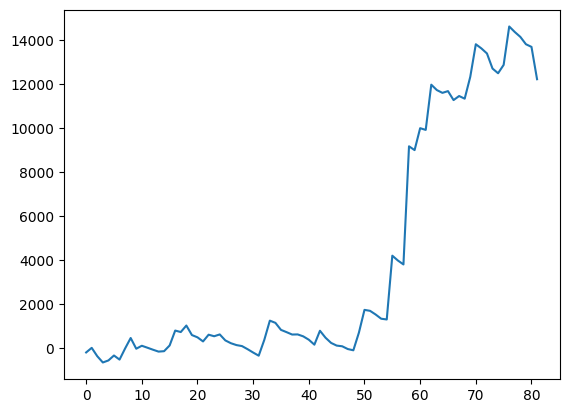

In [223]:
trade_log_df.pnl.cumsum().plot()

# <u>6. Computing Metrics</u>

In [228]:
pnl = trade_log_df['pnl']

In [234]:
pnl.cumsum()

0      -181.65
1        26.25
2      -352.95
3      -637.00
4      -544.60
        ...   
77    14360.10
78    14138.20
79    13805.50
80    13684.95
81    12217.70
Name: pnl, Length: 82, dtype: float64

In [240]:
#Max Drawdown in points
min(pnl.cumsum() - pnl.cumsum().cummax())

-2393.349999999995